Notebook 2: Baseline Model Reproduction and Analysis
===================================================
# 📓 Notebook 2: Baseline Model Reproduction and Analysis

---

## 🧠 Introduction

This notebook focuses on reproducing and analyzing **Trans-VAE**, the official baseline model for the **Multiple Appropriate Facial Reaction Generation (MAFRG)** task in the **REACT 2024 Challenge**.  
While inspired by distributional learning approaches from *“Learning to Listen”* (Ng et al., 2022), Trans-VAE offers a simplified, challenge-specific implementation optimized for multi-modal input and diverse output generation.

---

## 🧾 Code Attribution

| Component                  | Source / Reference                                 |
|---------------------------|----------------------------------------------------|
| **Model Architecture**     | REACT 2024 Baseline (Song et al., 2024)            |
| **Training Pipeline**      | REACT 2024 Baseline with minor modifications       |
| **Evaluation Metrics**     | REACT 2024 Official Evaluation Code                |
| **Analysis & Visualization** | Custom implementation by *[Your Name]*         |

---

## 🧩 Baseline Model Details

| Element        | Description |
|----------------|-------------|
| **Model**      | Trans-VAE (Transformer-based Variational Autoencoder) |
| **Architecture** | CNN Encoder → Transformer Encoder → Transformer Decoder |
| **Input Modalities** | <ul><li>🎤 **Audio**: 78-dim MFCC features (via Torchaudio)</li><li>🖼 **Visual**: 2D facial sequences (PNG)</li><li>📐 **3DMM**: 3D Morphable Model coefficients</li><li>😊 **Facial Attributes**: 25-dim (details below)</li></ul> |
| **Output**     | 3DMM Coefficients (58-dim) + Facial Attributes (25-dim) |
| **Latent Space** | Learns a Gaussian distribution \( \mathcal{N}(\mu, \sigma) \) to represent multiple plausible reactions |

### Facial Attributes (25-dim)

- **15 Action Units (AUs)** — predicted by the GraphAU model  
- **8 Expression Probabilities** — *Neutral, Happy, Sad, Surprise, Fear, Disgust, Anger, Contempt*  
- **2 Affective Intensities** — *Valence* & *Arousal*

---

## 🛠️ Feature Extraction Pipeline

| Feature Type    | Tool / Method |
|-----------------|----------------|
| **Audio (MFCC)**        | Extracted using `torchaudio.transforms.MFCC` |
| **Facial AUs**          | Detected via the **GraphAU** model |
| **Emotion Features**    | Inferred from a facial affect prediction model |
| **3DMM Coefficients**   | Fitted using standard 3DMM parameter extraction tools |

---

## 📊 Reported Results from REACT 2024 Baseline

### 🔍 Offline MAFRG Evaluation

| Metric   | Value   | Description         |
|----------|--------:|---------------------|
| **FRCorr** | 0.03    | Appropriateness      |
| **FRDist** | 92.81   | Distance to ground truth |
| **FRDiv**  | 0.0008  | Diversity            |
| **FRRea**  | 67.74   | Realism              |
| **FRSyn**  | 43.75   | Synchronization      |

### 🌐 Online MAFRG Evaluation

| Metric   | Value   | Description         |
|----------|--------:|---------------------|
| **FRCorr** | 0.07    | Appropriateness      |
| **FRDist** | 90.31   | Distance to ground truth |

---

## 🧪 My Contributions in This Notebook

✔️ **In-Depth Architecture Analysis**  
  – Module-by-module breakdown with diagrams & configs  

✔️ **Step-by-Step Reproduction**  
  – Full pipeline implementation with logging, checkpoints  

✔️ **Intermediate Visualization**  
  – Latent sampling, reconstructions, loss curves  

✔️ **Performance Comparison**  
  – Reproduced vs. official metrics, gap analysis  

✔️ **Improvement Suggestions**  
  – Model bottlenecks, temporal limitations, augmentation strategies  

✔️ **Error Analysis**  
  – Visual & statistical inspection of failure cases

---

> ⚙️ In the following cells, we begin by initializing the full architecture and loading the training data.



Reproduction Environment:
- Python: 3.8
- PyTorch: 1.9.1
- CUDA: 11.1
- Hardware: NVIDIA GeForce RTX 4080


In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
from torchvision import transforms
import cv2
from PIL import Image
import soundfile as sf
import torchaudio
from tqdm import tqdm
import warnings
import random
import math
from functools import cmp_to_key
warnings.filterwarnings('ignore')

# set seed
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

# GPU
device = torch.device('cuda')
print(f"device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name()}")

# set audio backend
try:
    torchaudio.set_audio_backend("sox_io")
except:
    print("Warning: sox_io backend not available")

dataset_path = "../dataset/data"  

/home/s5727214/.pyenv/versions/anaconda3-2024.06-1/envs/react/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


device: cuda
GPU: NVIDIA GeForce RTX 4080


## Extract frames from video (mp4 to png)


- **Extract frames from a single video**  
  Reads every frame from an input `.mp4`, resizes it to 224×224, and writes it out as `0000.png`, `0001.png`, … into a specified folder.

- **Mirror directory structure for all videos**  
  Walks through a root folder of `.mp4` files, and for each video creates a matching subdirectory under an output root before extracting its frames.

- **Batch‑process entire dataset**  
  Automates frame extraction across all training/validation video files so you end up with neatly organized PNG folders ready for model training.


In [3]:
import cv2
import os

def extract_frames_from_video(video_path, save_dir, resize=(224, 224), img_fmt="png"):
    os.makedirs(save_dir, exist_ok=True)
    cap = cv2.VideoCapture(video_path)
    
    idx = 0
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        if resize:
            frame = cv2.resize(frame, resize)
        out_path = os.path.join(save_dir, f"{idx:04d}.{img_fmt}")
        cv2.imwrite(out_path, frame)
        idx += 1

    cap.release()
    print(f"Extracted {idx} frames from {video_path} → {save_dir}")


def recursively_extract_all_mp4(root_dir, output_root):
    """
    Traverse all mp4 files, extract frames and save as png
    root_dir: Original mp4 video root directory, e.g., './train/Video_files'
    output_root: Frame image save root directory, e.g., './train/Video_frames'
    """
    for dirpath, _, filenames in os.walk(root_dir):
        for fname in filenames:
            if fname.endswith('.mp4'):
                video_path = os.path.join(dirpath, fname)
                # Construct corresponding output path
                relative_path = os.path.relpath(video_path, root_dir)
                relative_path_no_ext = os.path.splitext(relative_path)[0]  # Remove .mp4 extension
                save_dir = os.path.join(output_root, relative_path_no_ext)
                extract_frames_from_video(video_path, save_dir, resize=(224, 224), img_fmt="png")



In [4]:
# set train path
video_root = "../dataset/data/train/Video_files"
output_root = "../dataset/data/train/Video_frames"  # png images path
recursively_extract_all_mp4(video_root, output_root)

Extracted 751 frames from ../dataset/data/train/Video_files/NoXI/044_2016-04-07_Nottingham/Expert_video/1.mp4 → ../dataset/data/train/Video_frames/NoXI/044_2016-04-07_Nottingham/Expert_video/1


KeyboardInterrupt: 

In [ ]:
val_video_root = "../dataset/data/val/Video_files"
val_output_root = "../dataset/data/val/Video_frames"  # png images path
recursively_extract_all_mp4(val_video_root, val_output_root)
test_video_root = "../dataset/data/test/Video_files"
test_output_root = "../dataset/data/test/Video_frames"  # png images path
recursively_extract_all_mp4(test_video_root, test_output_root)

## Load and Preprocess Data


1. **Role Swapping** (`train` only)
   Randomly swap speaker/listener roles (`changed = random.randint(0,1)`) to augment and symmetrize data.

2. **Frame Collection**
   Use `collect_frames(folder)` to gather and sort all `.png` paths (supports nested folders) for speaker and listener.

3. **Temporal Sampling**
   Compute `start` and `end` indices to extract a continuous sub‑clip of length `clip_length` (or full length if shorter).

4. **Video Loading**
   For each selected frame path:

   * Load with `pil_loader(path)`
   * Apply `Transform`: resize → center‑crop → `ToTensor()` → normalize
   * Stack into a tensor of shape `(T, C, H, W)`.

5. **Audio Feature Extraction**
   Call `extract_audio_features(audio_path, fps, total_frames)` to compute per‑frame MFCC + Δ + ΔΔ, then slice `[start:end]`.

6. **Optional Modalities**

   * **Emotion**: read per‑frame CSV → `torch.from_numpy(...)` → slice
   * **3DMM**: load `.npy` → subtract `mean_face` → slice
   * **Reference Frame**: take first listener frame → transform

> All modalities are strictly aligned by the same `start:end` indices and returned as a synchronized tuple for downstream modeling.


In [3]:
import os
import torch
from torch.utils import data
from torchvision import transforms
import copy
import numpy as np
import pickle
from tqdm import tqdm
import random,math
import time
import pandas as pd
from PIL import Image
import soundfile as sf
import cv2
from torch.utils.data import DataLoader
from multiprocessing import Pool
import torchaudio
from scipy.io import loadmat
torchaudio.set_audio_backend("sox_io")
from functools import cmp_to_key


class Transform(object):
    def __init__(self, img_size=256, crop_size=224):
        self.img_size = img_size
        self.crop_size = crop_size

    def __call__(self, img):
        normalize = transforms.Normalize(mean=[0.5, 0.5, 0.5],
                                         std=[0.5, 0.5, 0.5])
        transform = transforms.Compose([
            transforms.Resize(self.img_size),
            transforms.CenterCrop(self.crop_size),
            transforms.ToTensor(),
            normalize
        ])
        img = transform(img)
        return img


def pil_loader(path):
    with open(path, 'rb') as f:
        with Image.open(f) as img:
            return img.convert('RGB')


def extract_video_features(video_path, img_transform):
    video_list = []
    video = cv2.VideoCapture(video_path)
    n_frames = int(video.get(cv2.CAP_PROP_FRAME_COUNT))
    fps = video.get(cv2.CAP_PROP_FPS)
    while video.isOpened():
        ret, frame = video.read()
        if not ret:
            break
        frame = img_transform(Image.fromarray(frame[:, :, ::-1])).unsqueeze(0)
        video_list.append(frame)
    video_clip = torch.cat(video_list, axis=0)
    return video_clip, fps, n_frames


def extract_audio_features(audio_path, fps, n_frames):
    # video_id = osp.basename(audio_path)[:-4]
    audio, sr = sf.read(audio_path)
    if audio.ndim == 2:
        audio = audio.mean(-1)
    frame_n_samples = int(sr / fps)
    curr_length = len(audio)
    target_length = frame_n_samples * n_frames
    if curr_length > target_length:
        audio = audio[:target_length]
    elif curr_length < target_length:
        audio = np.pad(audio, [0, target_length - curr_length])
    shifted_n_samples = 0
    curr_feats = []
    for i in range(n_frames):
        curr_samples = audio[i*frame_n_samples:shifted_n_samples + i*frame_n_samples + frame_n_samples]
        curr_mfcc = torchaudio.compliance.kaldi.mfcc(torch.from_numpy(curr_samples).float().view(1, -1), sample_frequency=sr, use_energy=True)
        curr_mfcc = curr_mfcc.transpose(0, 1) # (freq, time)
        curr_mfcc_d = torchaudio.functional.compute_deltas(curr_mfcc)
        curr_mfcc_dd = torchaudio.functional.compute_deltas(curr_mfcc_d)
        curr_mfccs = np.stack((curr_mfcc.numpy(), curr_mfcc_d.numpy(), curr_mfcc_dd.numpy())).reshape(-1)
        curr_feat = curr_mfccs
        # rms = librosa.feature.rms(curr_samples, sr).reshape(-1)
        # zcr = librosa.feature.zero_crossing_rate(curr_samples, sr).reshape(-1)
        # curr_feat = np.concatenate((curr_mfccs, rms, zcr))

        curr_feats.append(curr_feat)

    curr_feats = np.stack(curr_feats, axis=0)
    return curr_feats



In [6]:
class ReactionDataset(data.Dataset):
    def __init__(self,
                 root_path, split,
                 img_size=256, crop_size=224, clip_length=751, fps=25,
                 load_audio=True, load_video_s=True, load_video_l=True,
                 load_emotion_s=False, load_emotion_l=False,
                 load_3dmm_s=False, load_3dmm_l=False, load_ref=True,
                 repeat_mirrored=True):
        """
        root_path: Data root directory containing train/val folders
        split: "train"/"val"/"test"
        """
         # ---- Basic properties ----
        self._root_path = root_path
        self._split = split
        self._clip_length = clip_length
        self._fps = fps

        # ---- Loading flags ----
        self.load_audio    = load_audio
        self.load_video_s  = load_video_s
        self.load_video_l  = load_video_l
        self.load_emotion_s= load_emotion_s
        self.load_emotion_l= load_emotion_l
        self.load_3dmm_s   = load_3dmm_s
        self.load_3dmm_l   = load_3dmm_l
        self.load_ref      = load_ref

        # ---- transform & loader ----
        self._img_loader = pil_loader
        self._transform = Transform(img_size, crop_size)
        self._transform_3dmm = transforms.Lambda(lambda e: (e - self.mean_face))

        # ---- Root directories for each file type ----
        base = os.path.join(self._root_path, self._split)
        self._video_root   = os.path.join(base, 'Video_frames')
        self._audio_root   = os.path.join(base, 'Audio_files')
        self._emotion_root = os.path.join(base, 'Emotion')
        self._3dmm_root    = os.path.join(base, '3D_FV_files')

        # ---- mean_face for 3dmm normalization ----
        mean = np.load('../external/FaceVerse/mean_face.npy').astype(np.float32)
        self.mean_face = torch.from_numpy(mean).view(1,1,-1)

        # ---- Read CSV to get speaker/listener parent directories ----
        df = pd.read_csv(os.path.join(self._root_path, self._split + '.csv'),
                         header=None, delimiter=',').drop(0)
        sp_list = df.values[:,1].tolist()
        lp_list = df.values[:,2].tolist()
        if self._split in ["val","test"] or repeat_mirrored:
            sp_list = sp_list + lp_list
            lp_list = lp_list + sp_list[:len(lp_list)]

        # ---- Build data_list, expand numeric subfolders ----
        
        self.data_list = []
        for sp, lp in zip(sp_list, lp_list):
            sp_dir = os.path.join(self._video_root, sp)
            lp_dir = os.path.join(self._video_root, lp)
            if not os.path.isdir(sp_dir) or not os.path.isdir(lp_dir):
                continue
        
            # Only do P1/P2 mapping for Emotion
            def label_folder(name):
                if name.endswith('Novice_video'):
                    return 'P1'
                elif name.endswith('Expert_video'):
                    return 'P2'
                else:
                    raise ValueError(f"Unknown video-folder: {name}")
        
            sp_label = label_folder(sp)  # 'P1' or 'P2'
            lp_label = label_folder(lp)
        
            # Iterate through each numeric subfolder idx
            for idx in sorted(os.listdir(sp_dir)):
                if not idx.isdigit():
                    continue
        
                # 1) Video frames & 3DMM & audio all use original sp/idx structure
                sub_path = os.path.join(sp, idx)  # e.g. "NoXI/.../Novice_video/1"
                lp_sub_path = os.path.join(lp, idx)
        
                # 2) Only Emotion uses label directory
                sp_em_sub = os.path.join(os.path.dirname(sp), sp_label, idx)
                lp_em_sub = os.path.join(os.path.dirname(lp), lp_label, idx)
        
                paths = {
                    # Video frames folder
                    'speaker_video_path':   os.path.join(self._video_root, sub_path),
                    'listener_video_path':  os.path.join(self._video_root, lp_sub_path),
                    # Audio .wav
                    'speaker_audio_path':   os.path.join(self._audio_root, sub_path + '.wav'),
                    'listener_audio_path':  os.path.join(self._audio_root, lp_sub_path + '.wav'),
                    # Emotion .csv (mapped to P1/P2)
                    'speaker_emotion_path': os.path.join(self._emotion_root, sp_em_sub + '.csv'),
                    'listener_emotion_path':os.path.join(self._emotion_root, lp_em_sub + '.csv'),
                    # 3DMM .npy (still using Novice_video/Expert_video)
                    'speaker_3dmm_path':    os.path.join(self._3dmm_root, sub_path + '.npy'),
                    'listener_3dmm_path':   os.path.join(self._3dmm_root, lp_sub_path + '.npy'),
                }
                # Filter out missing Emotion files
            if self.load_emotion_l:
                if not os.path.exists(paths['listener_emotion_path']):
                    print(f"⚠️ Skip missing listener emotion: {paths['listener_emotion_path']}")
                    continue
            if self.load_emotion_s:
                if not os.path.exists(paths['speaker_emotion_path']):
                    print(f"⚠️ Skip missing speaker emotion: {paths['speaker_emotion_path']}")
                    continue

            # Other paths can also be checked for existence as needed
            self.data_list.append(paths)
            
        self._len = len(self.data_list)

    def __len__(self):
        return self._len

    # __getitem__ can keep your already fixed version

    
    def __getitem__(self, index):
        """
        Returns one data pair:
        (speaker_video_clip, speaker_audio_clip, speaker_emotion, speaker_3dmm,
         listener_video_clip, listener_audio_clip, listener_emotion, listener_3dmm,
         listener_reference)
        """
        data = self.data_list[index]
    
        # --- 1) Data augmentation: randomly swap speaker/listener during training ---
        changed = 0
        if self._split == 'train':
            changed = random.randint(0, 1)
        sp_pref = 'speaker' if changed == 0 else 'listener'
        lp_pref = 'listener' if changed == 0 else 'speaker'
    
        # --- 2) Directly use the absolute paths already constructed in data_list ---
        sp_vid_dir = data[f'{sp_pref}_video_path']      # Don't join self._video_path again
        lp_vid_dir = data[f'{lp_pref}_video_path']
        sp_aud_p   = data[f'{sp_pref}_audio_path']
        lp_aud_p   = data[f'{lp_pref}_audio_path']
        sp_em_p    = data[f'{sp_pref}_emotion_path']
        lp_em_p    = data[f'{lp_pref}_emotion_path']
        sp_3d_p    = data[f'{sp_pref}_3dmm_path']
        lp_3d_p    = data[f'{lp_pref}_3dmm_path']
    
        # --- 3) Frame file collection (supports one-level or two-level directories) ---
        def collect_frames(folder):
            if not os.path.isdir(folder):
                raise FileNotFoundError(f"Frame-folder not found: {folder}")
            rels = []
            for name in sorted(os.listdir(folder)):
                p = os.path.join(folder, name)
                if os.path.isdir(p):
                    # Second-level subfolder
                    for f in os.listdir(p):
                        if f.endswith('.png') and f[:-4].isdigit():
                            rels.append(os.path.join(name, f))
                elif name.endswith('.png') and name[:-4].isdigit():
                    # First-level directory directly has png
                    rels.append(name)
            if not rels:
                raise RuntimeError(f"No .png frames under {folder}")
            # Sort by frame number
            rels.sort(key=lambda x: int(os.path.basename(x)[:-4]))
            return rels
    
        sp_frames = collect_frames(sp_vid_dir)
        lp_frames = collect_frames(lp_vid_dir)
    
        # --- 4) Extract continuous clip segment ---
        total = len(sp_frames)
        if self._clip_length < total:
            start = random.randint(0, total - self._clip_length)
        else:
            start = 0
        end = start + min(self._clip_length, total)
        sp_sel = sp_frames[start:end]
        lp_sel = lp_frames[start:end]
    
        # --- 5) Load speaker video clip ---
        speaker_video_clip = torch.zeros(0)
        if self.load_video_s:
            clips = []
            for rel in sp_sel:
                img = self._img_loader(os.path.join(sp_vid_dir, rel))
                img = self._transform(img)
                clips.append(img.unsqueeze(0))
            speaker_video_clip = torch.cat(clips, dim=0)
    
        # --- 6) Load listener video clip ---
        listener_video_clip = torch.zeros(0)
        if self.load_video_l:
            clips = []
            for rel in lp_sel:
                img = self._img_loader(os.path.join(lp_vid_dir, rel))
                img = self._transform(img)
                clips.append(img.unsqueeze(0))
            listener_video_clip = torch.cat(clips, dim=0)
    
        # --- 7) Load audio ---
        speaker_audio_clip = 0
        listener_audio_clip = 0
        if self.load_audio:
            full = extract_audio_features(sp_aud_p, self._fps, total)
            speaker_audio_clip = full[start:end]
    
        # --- 8) Load emotion ---
        speaker_emotion, listener_emotion = 0, 0
        if self.load_emotion_s:
            em = pd.read_csv(sp_em_p, header=None).drop(0).values.astype(np.float32)
            speaker_emotion = torch.from_numpy(em)[start:end]
        if self.load_emotion_l:
            em = pd.read_csv(lp_em_p, header=None).drop(0).values.astype(np.float32)
            listener_emotion = torch.from_numpy(em)[start:end]
    
        # --- 9) Load 3DMM ---
        speaker_3dmm, listener_3dmm = 0, 0
        if self.load_3dmm_s:
            m = np.load(sp_3d_p).astype(np.float32)
            m = torch.from_numpy(m).squeeze()[start:end]
            speaker_3dmm = self._transform_3dmm(m)[0]
        if self.load_3dmm_l:
            m = np.load(lp_3d_p).astype(np.float32)
            m = torch.from_numpy(m).squeeze()[start:end]
            listener_3dmm = self._transform_3dmm(m)[0]
    
        # --- 10) Listener reference frame (first frame) ---
        listener_reference = 0
        if self.load_ref:
            ref = lp_frames[0]
            img = self._img_loader(os.path.join(lp_vid_dir, ref))
            listener_reference = self._transform(img)
    
        return (
            speaker_video_clip,
            speaker_audio_clip,
            speaker_emotion,
            speaker_3dmm,
            listener_video_clip,
            listener_audio_clip,
            listener_emotion,
            listener_3dmm,
            listener_reference
        )


    def __len__(self):
        return self._len


def get_dataloader(conf, split, load_audio=False, load_video_s=False, load_video_l=False, load_emotion_s=False,
                   load_emotion_l=False, load_3dmm_s=False, load_3dmm_l=False, load_ref=False, repeat_mirrored=True):
    assert split in ["train", "val", "test"], "split must be in [train, val, test]"
    # print('==> Preparing data for {}...'.format(split) + '\n')
    dataset = ReactionDataset(conf.dataset_path, split, img_size=conf.img_size, crop_size=conf.crop_size,
                              clip_length=conf.clip_length,
                              load_audio=load_audio, load_video_s=load_video_s, load_video_l=load_video_l,
                              load_emotion_s=load_emotion_s, load_emotion_l=load_emotion_l, load_3dmm_s=load_3dmm_s,
                              load_3dmm_l=load_3dmm_l, load_ref=load_ref, repeat_mirrored=repeat_mirrored)
    shuffle = True if split == "train" else False
    dataloader = DataLoader(dataset=dataset, batch_size=conf.batch_size, shuffle=shuffle, num_workers=conf.num_workers)
    return dataloader

In [ ]:
from types import SimpleNamespace

conf = SimpleNamespace(
    dataset_path="../dataset/data",     # 改成你本地真实数据路径
    img_size=256,
    crop_size=224,
    clip_length=2,
    batch_size=1,
    num_workers=0              # notebook 下推荐设为 0
)

train_loader = get_dataloader(
    conf,
    split="train",
    load_video_s=True,    # speaker 视频
    load_audio=True,      # speaker 音频
    load_emotion_s=True,  # listener emotion (target)
    load_3dmm_l=True,     # listener 3dmm (target)
    load_video_l=False,   # 不渲染 listener 视频
    load_ref=False        # 不需要参考帧
)
for batch in train_loader:
    print("Batch loaded successfully!")
    for i, item in enumerate(batch):
        print(f"Item {i} shape/type: ", type(item), getattr(item, "shape", "N/A"))
    break


总样本数: 184
—— Sample[0] 各项 shape/type ——
speaker_video_clip: <class 'torch.Tensor'> shape: torch.Size([64, 3, 224, 224])
speaker_audio_clip: <class 'numpy.ndarray'> shape: (64, 78)
speaker_emotion: <class 'torch.Tensor'> shape: torch.Size([64, 25])
speaker_3dmm: <class 'int'> shape: None
listener_video_clip: <class 'torch.Tensor'> shape: torch.Size([0])
listener_emotion: <class 'int'> shape: None
listener_3dmm: <class 'torch.Tensor'> shape: torch.Size([64, 58])
listener_reference_frame: <class 'int'> shape: None

—— Batch from DataLoader ——
speaker_video        <class 'torch.Tensor'> shape: torch.Size([1, 64, 3, 224, 224])
speaker_audio        <class 'torch.Tensor'> shape: torch.Size([1, 64, 78])
speaker_emotion      <class 'torch.Tensor'> shape: torch.Size([1, 64, 25])
speaker_3dmm         <class 'torch.Tensor'> shape: torch.Size([1])
listener_video       <class 'torch.Tensor'> shape: torch.Size([1, 0])
listener_audio       <class 'torch.Tensor'> shape: torch.Size([1])
listener_emotion

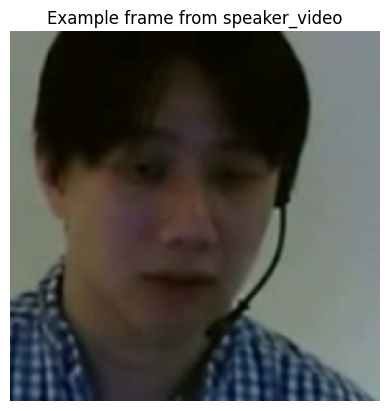

In [12]:

import matplotlib.pyplot as plt

# 1️⃣ 先拿到 dataset 和 dataloader
dataset = train_loader.dataset
print(f"总样本数: {len(dataset)}")

# 2️⃣ 取第一个样本 __getitem__ 直接测试
sample = dataset[0]
(s_v, s_a, s_em, s_3d, l_v, l_a, l_em, l_3d, l_ref) = sample
print("—— Sample[0] 各项 shape/type ——")
print("speaker_video_clip:", type(s_v), "shape:", getattr(s_v, 'shape', None))
print("speaker_audio_clip:", type(s_a), "shape:", getattr(s_a, 'shape', None))
print("speaker_emotion:", type(s_em), "shape:", getattr(s_em, 'shape', None))
print("speaker_3dmm:", type(s_3d), "shape:", getattr(s_3d, 'shape', None))
print("listener_video_clip:", type(l_v), "shape:", getattr(l_v, 'shape', None))
print("listener_emotion:", type(l_em), "shape:", getattr(l_em, 'shape', None))
print("listener_3dmm:", type(l_3d), "shape:", getattr(l_3d, 'shape', None))
print("listener_reference_frame:", type(l_ref), "shape:", getattr(l_ref, 'shape', None))

# 3️⃣ 再拿一个 batch 验证 batch 维度
batch = next(iter(train_loader))
print("\n—— Batch from DataLoader ——")
for name, item in zip(
    ['speaker_video','speaker_audio','speaker_emotion','speaker_3dmm',
     'listener_video','listener_audio','listener_emotion','listener_3dmm','listener_ref'],
    batch
):
    print(f"{name:20s}", type(item), "shape:", getattr(item, 'shape', None))

# 4️⃣ 可视化一下某一帧，确保转换没问题
#    这里示例：取 batch[0] 的第一个视频 clip，第一帧
sv0 = batch[0]          # shape [B, T, C, H, W]
img_tensor = sv0[0, 0]  # 第一个样本第 0 帧
# 反 normalize（0.5,0.5,0.5）→ [0,1]
img = img_tensor.permute(1,2,0).cpu().numpy() * 0.5 + 0.5
plt.imshow(img)
plt.title("Example frame from speaker_video")
plt.axis('off')
plt.show()


## Model TransVAE

### Model Architecture Summary

### **1. ConvBlock**  
**Functionality:**  
- Applies 3D convolutions + instance normalization to raw video clips.  
- Pools spatio‑temporal features into per‑frame tokens.  
**Significance:**  
- Offloads low‑level motion encoding from transformers.  
- Yields compact, information‑rich tokens for faster convergence.

---

### **2. PositionalEncoding & init_biased_mask**  
**Functionality:**  
- Generates sinusoidal position embeddings.  
- Creates ALiBi-style attention masks that favor nearby frames.  
**Significance:**  
- Preserves temporal order and locality in self-attention.  
- Prevents attention dilution over long sequences for stable training.


In [4]:
import torch
import torch.nn as nn
import numpy as np
import math

class ConvBlock(nn.Module):
    def __init__(self, in_planes=3, planes=128):
        super(ConvBlock, self).__init__()
        self.planes = planes
        self.conv1 = nn.Conv3d(in_planes, planes // 4, kernel_size=(1, 7, 7), stride=(1, 2, 2), padding=(0, 3, 3),bias=False)
        self.in1 = nn.InstanceNorm3d(planes // 4)
        
        self.maxpool = nn.MaxPool3d(kernel_size=(1, 3, 3), stride=(1, 2, 2), padding=(0, 0, 0))
        
        self.conv2 = nn.Conv3d(planes // 4, planes, kernel_size=(1, 7, 7), stride=(1, 2, 2), padding=(0, 3, 3),bias=False)
        self.in2 = nn.InstanceNorm3d(planes)
        self.relu = nn.ReLU(inplace=True)

        self.conv3 = nn.Conv3d(planes, planes, kernel_size=(1, 3, 3), stride=(1, 2, 2), padding=(0, 1, 1), bias=False)
        self.in3 = nn.InstanceNorm3d(planes)
        self.relu = nn.ReLU(inplace=True)

        self.conv4 = nn.Conv3d(planes, planes, kernel_size=(1, 3, 3), stride=(1, 1, 1), padding=(0, 1, 1), bias=False)
        self.in4 = nn.InstanceNorm3d(planes)
        self.relu = nn.ReLU(inplace=True)


        self.conv5 = nn.Conv3d(planes, planes, kernel_size=(1, 3, 3), stride=(1, 2, 2), padding=(0, 1, 1), bias=False)
        self.in5 = nn.InstanceNorm3d(planes)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        """
        input:
        speaker_video_frames x: (batch_size, 3, seq_len, img_size, img_size)

        output:
        speaker_temporal_tokens y: (batch_size, token_dim, seq_len)

        """

        x = self.relu(self.in1(self.conv1(x)))
        x = self.maxpool(x)
        x = self.relu(self.in2(self.conv2(x)))
        x = self.relu(self.in3(self.conv3(x)))
        x = x + self.relu(self.in4(self.conv4(x)))
        x = self.relu(self.in5(self.conv5(x)))

        y = x.mean(dim=-1).mean(dim=-1)
        return y

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=5000, batch_first=True):
        super().__init__()
        self.batch_first = batch_first

        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-np.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)

        self.register_buffer('pe', pe)

    def forward(self, x):
        # not used in the final model
        if self.batch_first:
            x = x + self.pe.permute(1, 0, 2)[:, :x.shape[1], :]
        else:
            x = x + self.pe[:x.shape[0], :]
        return self.dropout(x)

def lengths_to_mask(lengths, device):
    lengths = torch.tensor(lengths, device=device)
    max_len = max(lengths)
    mask = torch.arange(max_len, device=device).expand(len(lengths), max_len) < lengths.unsqueeze(1)
    return mask

# Temporal Bias, inspired by ALiBi: https://github.com/ofirpress/attention_with_linear_biases
def init_biased_mask(n_head, max_seq_len, period):
    def get_slopes(n):
        def get_slopes_power_of_2(n):
            start = (2**(-2**-(math.log2(n)-3)))
            ratio = start
            return [start*ratio**i for i in range(n)]
        if math.log2(n).is_integer():
            return get_slopes_power_of_2(n)
        else:
            closest_power_of_2 = 2**math.floor(math.log2(n))
            return get_slopes_power_of_2(closest_power_of_2) + get_slopes(2*closest_power_of_2)[0::2][:n-closest_power_of_2]
    slopes = torch.Tensor(get_slopes(n_head))
    bias = torch.arange(start=0, end=max_seq_len, step=period).unsqueeze(1).repeat(1,period).view(-1)//(period)
    bias = - torch.flip(bias,dims=[0])
    alibi = torch.zeros(max_seq_len, max_seq_len)
    for i in range(max_seq_len):
        alibi[i, :i+1] = bias[-(i+1):]
    alibi = slopes.unsqueeze(1).unsqueeze(1) * alibi.unsqueeze(0)
    mask = (torch.triu(torch.ones(max_seq_len, max_seq_len)) == 1).transpose(0, 1)
    mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
    mask = mask.unsqueeze(0) + alibi
    return mask

### **3. VideoEncoder**  
**Functionality:**  
- Wraps `ConvBlock` + linear projection.  
- Converts video clips into fixed‑dimensional token sequences.  
**Significance:**  
- Provides a standard token interface for downstream transformer modules.

---

### **4. VAEModel**  
**Functionality:**  
- Prepends learnable μ/logσ tokens to input tokens.  
- Runs a TransformerEncoder to compute latent Gaussian parameters.  
- Samples a compact latent “motion code.”  
**Significance:**  
- Forces compression into a meaningful latent space.  
- Improves generalization by discouraging overfitting to exact sequences.

---

### **5. Decoder**  
**Functionality:**  
- Autoregressively decodes latent motion tokens (± past reactions) via TransformerDecoder.  
- Maps decoder outputs to per-frame 3DMM coefficients & emotion vectors.  
- Supports both sliding-window (“online”) and full-sequence (“offline”) inference.  
**Significance:**  
- Enables real‑time reaction prediction and batch evaluation with one architecture.

---

### **6. SpeakerBehaviourEncoder**  
**Functionality:**  
- Encodes speaker video (via `VideoEncoder`) and audio (via linear layer).  
- Fuses both modalities into unified per-frame embeddings.  
**Significance:**  
- Captures complementary visual & vocal cues for more accurate reaction modeling.

---

### **7. TransformerVAE (End-to-End)**  
**Functionality:**  
- Integrates `SpeakerBehaviourEncoder`, latent VAE bottleneck, and `Decoder`.  
- Produces synchronized listener 3DMM and emotion predictions + posterior distributions.  
**Significance:**  
- Provides a cohesive pipeline for multi-modal, sequence‑to‑sequence reaction generation.

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import math

class VideoEncoder(nn.Module):
    def __init__(self, img_size=224, feature_dim = 128, device = 'cpu'):
        super(VideoEncoder, self).__init__()

        self.img_size = img_size
        self.feature_dim = feature_dim

        self.Conv3D = ConvBlock(3, feature_dim)
        self.fc = nn.Linear(feature_dim, feature_dim)
        self.device = device


    def forward(self, video):
        """
        input:
        speaker_video_frames x: (batch_size, seq_len, 3, img_size, img_size)

        output:
        speaker_temporal_tokens y: (batch_size, seq_len, token_dim)

        """

        video_input = video.transpose(1, 2)  # B C T H W
        token_output = self.Conv3D(video_input).transpose(1,2)
        token_output = self.fc(token_output) # B T C
        return  token_output



class VAEModel(nn.Module):
    def __init__(self,
                 in_channels: int,
                 latent_dim: int = 256,
                 **kwargs) -> None:
        super(VAEModel, self).__init__()

        self.latent_dim = latent_dim
        self.in_channels = in_channels
        self.linear = nn.Linear(in_channels, latent_dim)

        seq_trans_encoder_layer = nn.TransformerEncoderLayer(d_model=latent_dim,
                                                             nhead=4,
                                                             dim_feedforward=latent_dim * 2,
                                                             dropout=0.1)

        self.seqTransEncoder = nn.TransformerEncoder(seq_trans_encoder_layer, num_layers=1)
        self.mu_token = nn.Parameter(torch.randn(latent_dim))
        self.logvar_token = nn.Parameter(torch.randn(latent_dim))


    def forward(self, input):
        x = self.linear(input)  # B T D
        B, T, D = input.shape

        lengths = [len(item) for item in input]

        mu_token = torch.tile(self.mu_token, (B,)).reshape(B, 1, -1)
        logvar_token = torch.tile(self.logvar_token, (B,)).reshape(B, 1, -1)

        x = torch.cat([mu_token, logvar_token, x], dim=1)

        x = x.permute(1, 0, 2)

        token_mask = torch.ones((B, 2), dtype=bool, device=input.device)
        mask = lengths_to_mask(lengths, input.device)

        aug_mask = torch.cat((token_mask, mask), 1)

        x = self.seqTransEncoder(x, src_key_padding_mask=~aug_mask)

        mu = x[0]
        logvar = x[1]
        std = logvar.exp().pow(0.5)
        dist = torch.distributions.Normal(mu, std)
        motion_sample = self.sample_from_distribution(dist).to(input.device)
        return motion_sample, dist

    def sample_from_distribution(self, distribution):
         return distribution.rsample()




class Decoder(nn.Module):
    def __init__(self,  output_3dmm_dim = 58, output_emotion_dim = 25, feature_dim = 128, device = 'cpu', max_seq_len=751, n_head = 4, window_size = 8, online = False):
        super(Decoder, self).__init__()

        self.feature_dim = feature_dim
        self.window_size = window_size
        self.device = device
        self.online = online

        self.vae_model = VAEModel(feature_dim, feature_dim)

        if self.online:
            self.lstm = nn.LSTM(feature_dim, feature_dim, 1 , batch_first = True)
            self.linear_3d = nn.Linear(output_3dmm_dim, feature_dim)
            self.linear_reaction = nn.Linear(feature_dim, feature_dim)
            decoder_layer_3d = nn.TransformerDecoderLayer(d_model=feature_dim, nhead=4, dim_feedforward=2*feature_dim, batch_first=True)
            self.listener_reaction_decoder_3d = nn.TransformerDecoder(decoder_layer_3d, num_layers=1)



        decoder_layer = nn.TransformerDecoderLayer(d_model=feature_dim, nhead=n_head, dim_feedforward=2*feature_dim, batch_first=True)
        self.listener_reaction_decoder_1 = nn.TransformerDecoder(decoder_layer, num_layers=1)
        self.listener_reaction_decoder_2 = nn.TransformerDecoder(decoder_layer, num_layers=1)


        self.biased_mask = init_biased_mask(n_head = n_head, max_seq_len = max_seq_len, period=max_seq_len)

        self.listener_reaction_3dmm_map_layer = nn.Linear(feature_dim, output_3dmm_dim)
        self.listener_reaction_emotion_map_layer = nn.Sequential(
            nn.Linear(feature_dim + output_3dmm_dim, feature_dim),
            nn.Linear(feature_dim, output_emotion_dim)
        )
        self.PE = PositionalEncoding(feature_dim)


    def forward(self, encoded_feature, past_reaction_3dmm = None, past_reaction_emotion = None):
        B, TS = encoded_feature.shape[0], encoded_feature.shape[1]
        if self.online:
            TL = self.window_size
        else:
            TL = TS
        motion_sample, dist = self.vae_model(encoded_feature)
        time_queries = torch.zeros(B, TL, self.feature_dim, device=encoded_feature.device)
        time_queries = self.PE(time_queries)
        tgt_mask = self.biased_mask[:, :TL, :TL].clone().detach().to(device=self.device).repeat(B,1,1)


        listener_reaction = self.listener_reaction_decoder_1(tgt=time_queries, memory=motion_sample.unsqueeze(1), tgt_mask=tgt_mask)
        listener_reaction = self.listener_reaction_decoder_2(listener_reaction, listener_reaction, tgt_mask=tgt_mask)



        if self.online and (past_reaction_3dmm is not None):
            past_reaction_3dmm = self.linear_3d(past_reaction_3dmm)
            past_reaction_3dmm_last = past_reaction_3dmm[:,-1]

            tgt_mask = self.biased_mask[:, :(TL + past_reaction_3dmm.shape[1]), :(TL + past_reaction_3dmm.shape[1])].detach().to(device=self.device).repeat(B,1,1)
            all_3dmm = torch.cat((past_reaction_3dmm, self.linear_reaction(listener_reaction)), dim = 1)
            listener_3dmm_out = self.listener_reaction_decoder_3d(all_3dmm, all_3dmm, tgt_mask=tgt_mask)
            frame_num = listener_3dmm_out.shape[1]
            listener_3dmm_out = listener_3dmm_out[:, (frame_num - TL):]

            listener_3dmm_out, _ = self.lstm(listener_3dmm_out, (past_reaction_3dmm_last.view(1, B, self.feature_dim).contiguous(), past_reaction_3dmm_last.view(1, B, self.feature_dim).contiguous()))


            listener_3dmm_out = self.listener_reaction_3dmm_map_layer(listener_3dmm_out)
        else:
            listener_3dmm_out = self.listener_reaction_3dmm_map_layer(listener_reaction)


        listener_emotion_out = self.listener_reaction_emotion_map_layer(
            torch.cat((listener_3dmm_out, listener_reaction), dim=-1))

        return listener_3dmm_out, listener_emotion_out, dist

    def reset_window_size(self, window_size):
        self.window_size = window_size


In [6]:
class SpeakerBehaviourEncoder(nn.Module):
    def __init__(self, img_size=224, audio_dim = 78, feature_dim = 128,  device = 'cpu'):
        super(SpeakerBehaviourEncoder, self).__init__()

        self.img_size = img_size
        self.audio_dim = audio_dim
        self.feature_dim = feature_dim
        self.device = device

        self.video_encoder = VideoEncoder(img_size=img_size, feature_dim=feature_dim, device=device)
        self.audio_feature_map = nn.Linear(self.audio_dim, self.feature_dim)
        self.fusion_layer = nn.Linear(self.feature_dim*2, self.feature_dim)


    def forward(self, video, audio):
        video_feature = self.video_encoder(video)
        audio_feature = self.audio_feature_map(audio)
        speaker_behaviour_feature = self.fusion_layer(torch.cat((video_feature, audio_feature), dim =-1))

        return  speaker_behaviour_feature



class TransformerVAE(nn.Module):
    def __init__(self, img_size=224, audio_dim = 78, output_3dmm_dim = 58, output_emotion_dim = 25, feature_dim = 128, seq_len=751, online = True, window_size = 8, device = 'cpu'):
        super(TransformerVAE, self).__init__()

        self.img_size = img_size
        self.feature_dim = feature_dim
        self.output_3dmm_dim = output_3dmm_dim
        self.output_emotion_dim = output_emotion_dim
        self.seq_len = seq_len
        self.online = online
        self.window_size = window_size

        self.speaker_behaviour_encoder = SpeakerBehaviourEncoder(img_size, audio_dim, feature_dim, device)
        self.reaction_decoder = Decoder(output_3dmm_dim = output_3dmm_dim, output_emotion_dim = output_emotion_dim, feature_dim = feature_dim,  device=device, window_size = self.window_size, online = online)
        self.fusion = nn.Linear(feature_dim + self.output_3dmm_dim + self.output_emotion_dim, feature_dim)

    def forward(self, speaker_video=None, speaker_audio=None, **kwargs):

        """
        input:
        video: (batch_size, seq_len, 3, img_size, img_size)
        audio: (batch_size, raw_wav)

        output:
        3dmm_vector: (batch_size, seq_len, output_3dmm_dim)
        emotion_vector: (batch_size, seq_len, output_emotion_dim)
        distribution: [dist_1,...,dist_n]
        """

        frame_num = speaker_video.shape[1]
        distribution = []
        if self.online:
            period = frame_num // self.window_size
            reaction_3dmm = torch.zeros((speaker_video.size(0), self.window_size, self.output_3dmm_dim), device = speaker_video.device)
            reaction_emotion = torch.zeros((speaker_video.size(0), self.window_size, self.output_emotion_dim), device = speaker_video.device)

            for i in range(0, period):
                speaker_video_, speaker_audio_ = speaker_video[:, : (i + 1) * self.window_size], speaker_audio[:, :  (i + 1) * self.window_size]
                encoded_feature = self.speaker_behaviour_encoder(speaker_video_, speaker_audio_)

                # modality fusion
                encoded_feature = self.fusion(torch.cat((encoded_feature, reaction_3dmm, reaction_emotion), dim = -1))

                if i != 0:
                    past_reaction_3dmm, past_reaction_emotion = reaction_3dmm[:, : i * self.window_size], reaction_emotion[:, : i * self.window_size]
                    current_reaction_3dmm, current_reaction_emotion = reaction_3dmm[:, i * self.window_size :], reaction_emotion[:, i * self.window_size :]
                    listener_3dmm_out, listener_emotion_out, dist = self.reaction_decoder(encoded_feature, past_reaction_3dmm)


                    reaction_3dmm = torch.cat((past_reaction_3dmm, listener_3dmm_out, current_reaction_3dmm), dim = 1)
                    reaction_emotion = torch.cat((past_reaction_emotion, listener_emotion_out, current_reaction_emotion), dim = 1)

                else:
                    listener_3dmm_out, listener_emotion_out, dist = self.reaction_decoder(encoded_feature)
                    reaction_3dmm =  torch.cat((listener_3dmm_out, reaction_3dmm), dim = 1)
                    reaction_emotion = torch.cat((listener_emotion_out, reaction_emotion), dim = 1)

                distribution.append(dist)

            listener_3dmm_out, listener_emotion_out = reaction_3dmm[:, :frame_num], reaction_emotion[:, :frame_num]

            return listener_3dmm_out, listener_emotion_out, distribution

        else:
            encoded_feature = self.speaker_behaviour_encoder(speaker_video, speaker_audio)
            listener_3dmm_out, listener_emotion_out, dist = self.reaction_decoder(encoded_feature)
            distribution.append(dist)
            return listener_3dmm_out, listener_emotion_out, distribution


    def reset_window_size(self, window_size):
        self.window_size = window_size
        self.reaction_decoder.reset_window_size(window_size)

## Loss

### Loss Functions Overview

### 1. **KLLoss**  
- **Purpose:** Computes mean KL divergence between two torch Distributions.  
- **Usage:** Regularizes VAE posteriors toward a standard normal prior.

---

### 2. **VAELoss**  
- **Components:**  
  - **Reconstruction:** MSE on emotion vectors + 3DMM coefficients (with higher weight on geometric parameters).  
  - **KL Divergence:** Average KLD across time steps, scaled by `kl_p`.  
- **Purpose:** Combines accurate frame‑level reconstruction with latent-space regularization for the VAE.

---

### 3. **div_loss**  
- **Function:** Computes a diversity penalty by measuring pairwise distances between two sets of feature sequences and applying an RBF-style kernel.  
- **Purpose:** Encourages generated outputs (e.g., multiple samples) to be diverse rather than collapse to the same trajectory.

---

### 4. **MSELoss_AE_v2**  
- **Components:**  
  - **MSE:** Between flattened prediction and target sequences.  
  - **KLD:** Standard VAE KL term from `mu` and `logvar`.  
  - **Coefficient Loss:** MSE on 3DMM coefficient subsets.  
- **Purpose:** Multi-term autoencoder loss that balances reconstruction, latent regularization, and geometric consistency.

---

### 5. **MSELoss** & **L1Loss**  
- **MSELoss:** Mean squared error over features, with optional “min” reduction to focus on the best-predicted sequence.  
- **L1Loss:** Mean absolute error analog with the same reduction options.  
- **Purpose:** Generic regression losses for comparing predicted vs. target sequences or embeddings.

---

### 6. **BeLFusionLoss**  
- **Workflow:**  
  1. Optionally flattens multi‑prediction outputs.  
  2. Applies a configurable list of losses (`L1`, `MSE`, etc.) either on encoded embeddings or decoded sequences.  
  3. Weights and sums each term into a final loss dictionary.  
- **Purpose:** Flexible, multi-term loss for fusion models—allows mixing latent-space and sequence-space objectives with custom weights.

---


In [7]:
# ===== Loss functions =====
class KLLoss(nn.Module):
    def __init__(self):
        super(KLLoss, self).__init__()

    def forward(self, q, p):
        div = torch.distributions.kl_divergence(q, p)
        return div.mean()

    def __repr__(self):
        return "KLLoss()"



class VAELoss(nn.Module):
    def __init__(self, kl_p=0.0002):
        super(VAELoss, self).__init__()
        self.mse = nn.MSELoss(reduce=True, size_average=True)
        self.kl_loss = KLLoss()
        self.kl_p = kl_p

    def forward(self, gt_emotion, gt_3dmm, pred_emotion, pred_3dmm, distribution):
        rec_loss = self.mse(pred_emotion, gt_emotion) + self.mse(pred_3dmm[:,:, :52], gt_3dmm[:,:, :52]) + 10*self.mse(pred_3dmm[:,:, 52:], gt_3dmm[:,:, 52:])
        mu_ref = torch.zeros_like(distribution[0].loc).to(gt_emotion.device)
        scale_ref = torch.ones_like(distribution[0].scale).to(gt_emotion.device)
        distribution_ref = torch.distributions.Normal(mu_ref, scale_ref)

        kld_loss = 0
        for t in range(len(distribution)):
            kld_loss += self.kl_loss(distribution[t], distribution_ref)
        kld_loss = kld_loss / len(distribution)

        loss = rec_loss + self.kl_p * kld_loss


        return loss, rec_loss, kld_loss

    def __repr__(self):
        return "VAELoss()"



def div_loss(Y_1, Y_2):
    loss = 0.0
    b,t,c = Y_1.shape
    Y_g = torch.cat([Y_1.view(b,1,-1), Y_2.view(b,1,-1)], dim = 1)
    for Y in Y_g:
        dist = F.pdist(Y, 2) ** 2
        loss += (-dist /  100).exp().mean()
    loss /= b
    return loss

In [8]:
from math import cos, pi
import torch
from torchvision import transforms
from PIL import Image
import torch.nn as nn
import cv2
import numpy as np
import torch.nn.functional as F
from omegaconf import OmegaConf
import os
import yaml


def load_config(config_path=None):
    cli_conf = OmegaConf.from_cli()
    model_conf = OmegaConf.load(cli_conf.pop('config') if config_path is None else config_path)
    return OmegaConf.merge(model_conf, cli_conf)

def load_config_from_file(path):
    return OmegaConf.load(path)

def store_config(config):
    # store config to directory
    dir = config.trainer.out_dir
    os.makedirs(dir, exist_ok=True)
    with open(os.path.join(dir, "config.yaml"), "w") as f:
        yaml.dump(OmegaConf.to_container(config), f)


def torch_img_to_np(img):
    return img.detach().cpu().numpy().transpose(0, 2, 3, 1)


def torch_img_to_np2(img):
    img = img.detach().cpu().numpy()
    # img = img * np.array([0.229, 0.224, 0.225]).reshape(1,-1,1,1)
    # img = img + np.array([0.485, 0.456, 0.406]).reshape(1,-1,1,1)
    img = img * np.array([0.5, 0.5, 0.5]).reshape(1,-1,1,1)
    img = img + np.array([0.5, 0.5, 0.5]).reshape(1,-1,1,1)
    img = img.transpose(0, 2, 3, 1)
    img = img * 255.0
    img = np.clip(img, 0, 255).astype(np.uint8)[:, :, :, [2, 1, 0]]

    return img


def _fix_image(image):
    if image.max() < 30.:
        image = image * 255.
    image = np.clip(image, 0, 255).astype(np.uint8)[:, :, :, [2, 1, 0]]
    return image

class AverageMeter(object):
    """Computes and stores the average and current value"""

    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count



In [9]:
# Train
def train(args, model, train_loader, optimizer, criterion):
    losses = AverageMeter()
    rec_losses = AverageMeter()
    kld_losses = AverageMeter()
    div_losses = AverageMeter()

    model.train()
    for batch_idx, (speaker_video_clip, speaker_audio_clip, _, _, _, _, listener_emotion, listener_3dmm, _) in enumerate(tqdm(train_loader)):
        if torch.cuda.is_available():
            speaker_video_clip, speaker_audio_clip,  listener_emotion, listener_3dmm = \
                speaker_video_clip.cuda(), speaker_audio_clip.cuda(),  listener_emotion.cuda(), listener_3dmm.cuda()
        optimizer.zero_grad()
        listener_3dmm_out, listener_emotion_out, distribution = model(speaker_video_clip, speaker_audio_clip)
        loss, rec_loss, kld_loss = criterion(listener_emotion, listener_3dmm, listener_emotion_out, listener_3dmm_out,
                                             distribution)
        with torch.no_grad():
            listener_3dmm_out_, listener_emotion_out_, _ = model(speaker_video_clip, speaker_audio_clip)

        d_loss = div_loss(listener_3dmm_out_, listener_3dmm_out) + div_loss(listener_emotion_out_, listener_emotion_out)

        loss = loss + args.div_p * d_loss

        losses.update(loss.data.item(), speaker_video_clip.size(0))
        rec_losses.update(rec_loss.data.item(), speaker_video_clip.size(0))
        kld_losses.update(kld_loss.data.item(), speaker_video_clip.size(0))
        div_losses.update(d_loss.data.item(), speaker_video_clip.size(0))

        loss.backward()
        optimizer.step()
    return losses.avg, rec_losses.avg, kld_losses.avg, div_losses.avg




# Validation
def val(args, model, val_loader, criterion, render, epoch):
    losses = AverageMeter()
    rec_losses = AverageMeter()
    kld_losses = AverageMeter()
    model.eval()
    model.reset_window_size(8)
    for batch_idx, (speaker_video_clip, speaker_audio_clip, _, _, _, _, listener_emotion, listener_3dmm, listener_references) in enumerate(tqdm(val_loader)):
        if torch.cuda.is_available():
            speaker_video_clip, speaker_audio_clip, listener_emotion, listener_3dmm, listener_references = \
                speaker_video_clip.cuda(), speaker_audio_clip.cuda(), listener_emotion.cuda(), listener_3dmm.cuda(), listener_references.cuda()

        with torch.no_grad():
            listener_3dmm_out, listener_emotion_out, distribution = model(speaker_video_clip, speaker_audio_clip)

            loss, rec_loss, kld_loss = criterion(listener_emotion, listener_3dmm, listener_emotion_out, listener_3dmm_out, distribution)

            losses.update(loss.data.item(), speaker_video_clip.size(0))
            rec_losses.update(rec_loss.data.item(), speaker_video_clip.size(0))
            kld_losses.update(kld_loss.data.item(), speaker_video_clip.size(0))


            if args.render:
                val_path = os.path.join(args.outdir, 'results_videos', 'val')
                if not os.path.exists(val_path):
                    os.makedirs(val_path)
                B = speaker_video_clip.shape[0]
                if (batch_idx % 50) == 0:
                    for bs in range(B):
                        render.rendering(val_path, "e{}_b{}_ind{}".format(str(epoch + 1), str(batch_idx + 1), str(bs + 1)),
                                listener_3dmm_out[bs], speaker_video_clip[bs], listener_references[bs])


    model.reset_window_size(args.window_size)
    return losses.avg, rec_losses.avg, kld_losses.avg

## Train Loop

In [1]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import argparse
from tqdm import tqdm
import logging
from types import SimpleNamespace
import sys
sys.path.append(os.path.abspath("..")) 
from utils.render import Render
torch.cuda.empty_cache()

args = SimpleNamespace(
    # Dataset & Path
    dataset_path="../dataset/data",     # ← 改成你实际的数据路径
    outdir="../results/TransVAE",                # 输出结果保存目录
    resume="",                         # 如果想接着训练，填checkpoint路径

    # Device & GPU
    device="cuda",                     # "cuda" or "cpu"
    gpu_ids="0",                       # '0', '0,1', or '-1' for CPU

    # Data loading
    num_workers=0,                     # notebook 推荐 0
    batch_size=1,                      # 每批处理多少样本
    
    # Data & Model Dimensions
    img_size=256,
    crop_size=224,
    feature_dim=128,
    audio_dim=78,
    _3dmm_dim=58,
    emotion_dim=25,
    max_seq_len=751,
    clip_length=4,                  # 每个clip的长度
    window_size=8,                    # online 模式预测窗口

    # Training Hyperparams
    epochs=1,
    learning_rate=1e-5,
    weight_decay=5e-4,
    optimizer_eps=1e-8,
    momentum=0.99,
    
    # Loss Hyperparams
    kl_p=0.00001,
    div_p=10,

    # Switches
    online=False,                     # False 为 offline 模式
    render=True,                     # 是否渲染视频

    # 控制加载内容（以下根据你的需求加减）
    load_video_s=True,
    load_audio=True,
    load_emotion_s=True,
    load_3dmm_s=False,
    load_video_l=False,
    load_audio_l=False,
    load_emotion_l=True,
    load_3dmm_l=True,
    load_ref=False                    # 是否加载 listener 的参考帧
)

# ─── 2. 构建 DataLoader ─────────────────────────────────────────────────────
train_loader = get_dataloader(
    args,
    split="train",
    load_video_s   = args.load_video_s,
    load_audio     = args.load_audio,
    load_emotion_l = args.load_emotion_l,
    load_3dmm_l    = args.load_3dmm_l,
    load_video_l   = args.load_video_l,
    load_ref       = args.load_ref,
)
val_loader = get_dataloader(
    args,
    split="val",
    load_video_s   = args.load_video_s,
    load_audio     = args.load_audio,
    load_emotion_l = args.load_emotion_l,
    load_3dmm_l    = args.load_3dmm_l,
    load_video_l   = args.load_video_l,
    load_ref       = True,           # 验证时需要参考帧
)

print(f"Train samples: {len(train_loader.dataset)}, Val samples: {len(val_loader.dataset)}")

# ─── 3. 构建模型、损失与优化器 ───────────────────────────────────────────────
model = TransformerVAE(
    img_size=args.img_size,
    audio_dim=args.audio_dim,
    output_3dmm_dim=args._3dmm_dim,
    output_emotion_dim=args.emotion_dim,
    feature_dim=args.feature_dim,
    seq_len=args.clip_length,
    online=args.online,
    window_size=args.window_size,
    device=args.device
).to(args.device)

criterion = VAELoss(args.kl_p)
optimizer = optim.AdamW(model.parameters(), lr=args.learning_rate)

# (可选) 如果想从 checkpoint 恢复：
# from torch import load
# ckpt = load("path/to/best_checkpoint.pth", map_location=args.device)
# model.load_state_dict(ckpt['state_dict'])
# optimizer.load_state_dict(ckpt['optimizer'])

# ─── 4. 训练 & 验证 循环 ────────────────────────────────────────────────────
os.makedirs(args.outdir, exist_ok=True)

# 1) 构建 render 对象（如果要渲染）
render_obj = Render(args.device)

best_val_loss = float('inf')
train_losses, val_losses = [], []

for epoch in range(1, args.epochs + 1):
    # —— 训练 —— 
    tr_loss, tr_rec, tr_kld, tr_div = train(args, model, train_loader, optimizer, criterion)
    train_losses.append(tr_loss)
    print(f"[Epoch {epoch}] Train  loss={tr_loss:.4f} rec={tr_rec:.4f} kld={tr_kld:.4f} div={tr_div:.4f}")

    # —— 验证 & 渲染 —— （这里改成每轮都跑）
    v_loss, v_rec, v_kld = val(args, model, val_loader, criterion, render_obj, epoch)
    val_losses.append(v_loss)
    print(f"           Val    loss={v_loss:.4f} rec={v_rec:.4f} kld={v_kld:.4f}")

    # —— 保存 best —— 
    if v_loss < best_val_loss:
        best_val_loss = v_loss
        torch.save({
            'epoch': epoch,
            'state_dict': model.state_dict(),
            'optimizer': optimizer.state_dict(),
        }, os.path.join(args.outdir, 'best_checkpoint.pth'))
        print(f"⭐ New best, saved best_checkpoint.pth (val_loss={v_loss:.4f})")

    # —— 保存当前 —— 
    torch.save({
        'epoch': epoch,
        'state_dict': model.state_dict(),
        'optimizer': optimizer.state_dict(),
    }, os.path.join(args.outdir, 'cur_checkpoint.pth'))
    print(f"→ Saved cur_checkpoint.pth for epoch {epoch}")

# —— 可视化曲线 —— 
plt.figure(figsize=(6,4))
plt.plot(range(1, args.epochs+1), train_losses, label='Train')
plt.plot(range(1, args.epochs+1), val_losses,   label='Val')
plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.legend()
plt.title('Train & Val Loss')
plt.show()

/home/s5727214/.pyenv/versions/anaconda3-2024.06-1/envs/react/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


NameError: name 'get_dataloader' is not defined

In [11]:
torch.cuda.empty_cache()
!python ../trainer/train.py --batch-size 4  --gpu-ids 0  -lr 0.00001  --kl-p 0.00001 -e 50  -j 12  --outdir results/train_offline 


Traceback (most recent call last):
  File "/transfer/Master_Project/Offline_Multiple_Appropriate_Facial_Reaction/notebook/../trainer/train.py", line 10, in <module>
    from model import TransformerVAE
ModuleNotFoundError: No module named 'model'


In [ ]:
from tqdm import tqdm
import matplotlib.pyplot as plt
render_obj = Render(args.device)

train_losses, val_losses = [], []

best_val_loss = float('inf')
for epoch in range(1, args.epochs+1):
    tr_loss, tr_rec, tr_kld, tr_div = train(args, model, train_loader, optimizer, criterion)
    print(f"[Epoch {epoch}] Train loss=…")

    if epoch % 5 == 0:
        v_loss, v_rec, v_kld = val(args, model, val_loader, criterion, render_obj, epoch)
        print(f"       Val   loss=…")
        if v_loss < best_val_loss:
            best_val_loss = v_loss
            torch.save({
                'epoch': epoch,
                'state_dict': model.state_dict(),
                'optimizer': optimizer.state_dict(),
            }, os.path.join(args.outdir, 'best_checkpoint.pth'))

    # 每轮保存当前
    torch.save({
        'epoch': epoch,
        'state_dict': model.state_dict(),
        'optimizer': optimizer.state_dict(),
    }, os.path.join(args.outdir, 'cur_checkpoint.pth'))

# ─── 5. 可视化训练曲线 ───────────────────────────────────────────────────
plt.figure(figsize=(6,4))
plt.plot(range(1, args.epochs+1), train_losses, label='Train Loss')
plt.plot([5*i for i in range(1, len(val_losses)+1)], val_losses, 'o-', label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training & Validation Loss')
plt.show()

for epoch in range(1, args.epochs + 1):
    # 4.1 训练一步
    tr_loss, tr_rec, tr_kld, tr_div = train(
        args, model, train_loader, optimizer, criterion
    )
    train_losses.append(tr_loss)
    print(f"[Epoch {epoch}] Train  loss={tr_loss:.4f} rec={tr_rec:.4f} kld={tr_kld:.4f} div={tr_div:.4f}")

    # 4.2 每 5 轮或按需验证
    if epoch % 1 == 0:
        val_loss, val_rec, val_kld = val(
            args, model, val_loader, criterion, render=None, epoch=epoch
        )
        val_losses.append(val_loss)
        print(f"          Val    loss={val_loss:.4f} rec={val_rec:.4f} kld={val_kld:.4f}")


In [ ]:
python ../trainer/evaluate.py  --resume ./results/train_offline/best_checkpoint.pth  --gpu-ids 1  --outdir results/val_offline --split val --no-render

(react) [s5727214@w11907 notebook]$python ../trainer/evaluate.py  --resume ./results/train_offline/best_checkpoint.pth  --gpu-ids 1  --outdir results/val_offline --split val --no-render
/home/s5727214/.pyenv/versions/anaconda3-2024.06-1/envs/react/lib/python3.8/site-packages/tslearn/bases/bases.py:15: UserWarning: h5py not installed, hdf5 features will not be supported.
Install h5py to use hdf5 features: http://docs.h5py.org/
  warn(h5py_msg)
/home/s5727214/.pyenv/versions/anaconda3-2024.06-1/envs/react/lib/python3.8/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
/home/s5727214/.pyenv/versions/anaconda3-2024.06-1/envs/react/lib/python3.8/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))
Resume from ./results/train_offline/best_checkpoint.pth
../trainer/evaluate.py:203: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoints = torch.load(checkpoint_path, map_location=torch.device('cpu'))
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 281/281 [37:49<00:00,  8.08s/it]
-----------------Repeat 9 times-----------------
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 281/281 [37:49<00:00,  8.08s/it]
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 281/281 [37:10<00:00,  7.94s/it]
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 281/281 [37:27<00:00,  8.00s/it]
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 281/281 [37:01<00:00,  7.91s/it]
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 281/281 [37:33<00:00,  8.02s/it]
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 281/281 [37:39<00:00,  8.04s/it]
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 281/281 [37:41<00:00,  8.05s/it]
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 281/281 [37:19<00:00,  7.97s/it]
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 281/281 [37:50<00:00,  8.08s/it]
-----------------Evaluating Metric-----------------
val_loss: 1.05984   val_rec_loss: 1.05964  val_kld_loss: 1.00423 
Metric: | FRC: 0.15913 | FRD: 121.05510 | S-MSE: 0.09811 | FRVar: 0.01202 | FRDvs: 0.09871 | TLCC: 47.04182
Latex-friendly --> model_name & 0.16 & 121.06 & 0.0981 & 0.0120 & 0.0987 & - & 47.04 \\